In [1]:
#implement transformer model in pytorch

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#for monitoring
from time import time
#for parsing the data filename
import re

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# We create words from the set { 10,11,..99}
# Each word has a type {10,11,..19} are of type 1, and {20,21...29} are of type 2 etc
# 0 is the type for unknown

#we let the model remember a random sequence of words eg [ 23, 45, 56, 99, 11, 25 ]
#then we query with a type eg: 4 and the model should give out the first word of that type. here 45


In [5]:
#Model has two parts
#1. An encoder that takes in the random input sequence to remember
#   it outputs a memory vector
#2. A decoder that takes the memory vector and a type query
#   it outputs the word of that type from memory; if none 0 os output

In [6]:
#simpleEncoder is just a addition of word embeddings
#simple Decoder is a two layer Fully Connected network with softmax output

In [7]:
class Embedding(nn.Module) :
    def __init__(self, src_vocab_size, enbedding_vector_size ):
        super(Embedding, self).__init__()
        self.enbedding_vector_size = enbedding_vector_size
        self.embedding = nn.Embedding(src_vocab_size, self.enbedding_vector_size )
        
    def forward(self, input) :
        """input is of shape (batch, seq_length)"""
        self.emb = self.embedding(input)
        return self.emb #(batch.seq, emb)
    
    
class EncoderSimple(nn.Module):
    def __init__(self):
        super(EncoderSimple, self).__init__()
        
    def forward(self, x ):
        """input is of shape (batch.seq, emb)"""
        self.out = torch.sum(x,dim=1) #we sum over the sequence length
        return self.out
    
    
class EncoderRNN(nn.Module):
    def __init__(self, src_vocab_size, hidden_size, num_layers=1 ):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)

    def forward(self, input, hidden):
        self.output, self.hidden = self.gru(input, hidden)
        return self.output, self.hidden

    def init_hidden(self):
        result = torch.zeros(1, 1, self.hidden_size)   
        return result 
    
    
class EncoderFFN(nn.Module) :
    def __init__(self, sequence_length, d_model, d_hidden, d_out ):
        super(EncoderFFN, self).__init__()
        self.sequence_length = sequence_length
        self.ffn = FFN( d_model*sequence_length, d_hidden, d_out )
        
    def forward( self, x ) :  #x (batch, seq, emb)
        #we need to flaten it
        x = x.view(x.shape[0], -1)
        self.out = self.ffn(x)
        return self.out

In [8]:
class FFN( nn.Module ) : #forward network    
    def __init__( self, d_model, n_class, d_hidden ) :
        super(FFN, self).__init__() 
        
        self.w1 = nn.Linear( d_model,  d_hidden )
        #there will be a relu inbetween
        self.w2 = nn.Linear( d_hidden, n_class )

    def forward( self, x ) :
        """
        x  (batch, d_model)
        output (batch, n_class)
        """
        out = self.w2( F.relu( self.w1(x) ))
        return out #(batch, n_class)
        

In [9]:
class MemorySimple( nn.Module ) :
    def __init__( self, d_model=32, vocab_size=100, enbedding_vector_size=32, d_hidden=32 ) :
        super(Memory, self).__init__()
        
        assert(d_model == enbedding_vector_size) #for simple encoder is just a sum
        
        self.embedding = Embedding( vocab_size, enbedding_vector_size )
        #self.encoder   = EncoderSimple()
        self.encoder   = EncoderRNN(vocab_size, enbedding_vector_size )
        self.decoder   = FFN( d_model*2, vocab_size, d_hidden )
        
    def forward( self, input, query ) :
        self.emb = self.embedding( input )
        self.query = self.embedding( query ).squeeze(1)
        
        out, self.memory = self.encoder( self.emb, self.encoder.init_hidden() )
        
        self.merge = torch.cat( (self.memory.squeeze(1), self.query), dim=1 ) #cat the vectors together
        
        self.scores = self.decoder(self.merge)
        
        #self.out = F.softmax( self.scores, dim=1 )
        
        return self.scores

class MemoryRNN_encout( nn.Module ) :
    def __init__( self, d_model=32, vocab_size=100, enbedding_vector_size=32, d_hidden=32 ) :
        super(Memory, self).__init__()
        
        assert(d_model == enbedding_vector_size) #for simple encoder is just a sum
        
        self.embedding = Embedding( vocab_size, enbedding_vector_size )
        self.encoder   = EncoderRNN(vocab_size, enbedding_vector_size )
        self.ln        = nn.LayerNorm(enbedding_vector_size)
        self.decoder   = FFN( d_model*2, vocab_size, d_hidden )
        
    def forward( self, input, query ) :
        self.emb = self.embedding( input )
        self.query = self.embedding( query ).squeeze(1)
        
        self.enc_out, self.hidden = self.encoder( self.emb, torch.zeros(1, input.shape[0], self.encoder.hidden_size) )
        
        self.memory = self.ln( self.enc_out ) #self.enc_out #XXX check LN 
        
        self.merge = torch.cat( (self.memory[:,-1,:], self.query), dim=1 ) #cat the vectors together
        
        self.scores = self.decoder(self.merge)
        
        #self.out = F.softmax( self.scores, dim=1 )
        
        return self.scores
    
#Best model    
class MemoryRNN( nn.Module ) :
    def __init__( self, d_model=32, vocab_size=100, enbedding_vector_size=32, d_hidden=32 ) :
        super(Memory, self).__init__()
        
        assert(d_model == enbedding_vector_size) #for simple encoder is just a sum
        
        self.embedding = Embedding( vocab_size, enbedding_vector_size )
        self.encoder   = EncoderRNN(vocab_size, enbedding_vector_size )
        self.ln        = nn.LayerNorm(enbedding_vector_size)
        self.decoder   = FFN( d_model*2, vocab_size, d_hidden )
        
    def forward( self, input, query ) :
        self.emb = self.embedding( input )
        self.query = self.embedding( query ).squeeze(1)
        
        self.enc_out, self.hidden = self.encoder( self.emb, torch.zeros(1, input.shape[0], self.encoder.hidden_size) )
        
        self.memory = self.ln( self.hidden )  
        
        self.merge = torch.cat( (self.memory[:,-1,:], self.query), dim=1 ) #cat the vectors together
        
        self.scores = self.decoder(self.merge)
        
        #self.out = F.softmax( self.scores, dim=1 )
        
        return self.scores
    
    
def one_hot_vectors( vocab_size, enbedding_vector_size ) :
    """create one hot vectors of size enbedding_vector_size
    Out put shape is (vocab, enb_size)
    """
    
class Memory( nn.Module ) :
    def __init__( self, d_model=32, vocab_size=100, enbedding_vector_size=32, d_hidden=32 ) :
        super(Memory, self).__init__()
        
        #assert(d_model == enbedding_vector_size) #for simple encoder is just a sum
        
        self.embedding = nn.Embedding( vocab_size, enbedding_vector_size)
        
        #XXX Just fix some random vectors
        #w = torch.randn(vocab_size, enbedding_vector_size, requires_grad=False)
        #self.embedding = nn.Embedding( vocab_size, enbedding_vector_size).from_pretrained(w)
        
        #assert(vocab_size==enbedding_vector_size)
        #self.embedding = nn.Embedding( vocab_size, enbedding_vector_size).from_pretrained(torch.eye(vocab_size))
        
        self.encoder   = EncoderRNN(vocab_size, enbedding_vector_size )
        self.ln        = nn.LayerNorm(enbedding_vector_size)
        self.decoder   = FFN( d_model*2, vocab_size, d_hidden )
        
    def forward( self, input, query ) :
        self.emb = self.embedding( input )
        self.query = self.embedding( query ).squeeze(1)
        
        self.enc_out, self.hidden = self.encoder( self.emb, torch.zeros(1, input.shape[0], self.encoder.hidden_size).to(device) )
        
        self.memory = self.ln( self.hidden.squeeze(0) )  
        
        self.merge = torch.cat( (self.memory, self.query), dim=1 ) #cat the vectors together
        
        self.scores = self.decoder(self.merge)
        
        #self.out = F.softmax( self.scores, dim=1 )
        
        return self.scores
    
class MemoryFFN( nn.Module ) :
    def __init__( self, d_model=32, vocab_size=100, enbedding_vector_size=32, d_hidden=32, sequence_length=8 ) :
        super(Memory, self).__init__()
        
        assert(d_model == enbedding_vector_size) #for simple encoder is just a sum
        
        self.embedding = Embedding( vocab_size, enbedding_vector_size )
        #self.encoder   = EncoderSimple()
        self.encoder   = EncoderFFN( sequence_length, d_model, d_hidden, enbedding_vector_size )
        self.ln        = nn.LayerNorm(enbedding_vector_size)
        self.decoder   = FFN( d_model*2, vocab_size, d_hidden )
        
    def forward( self, input, query ) :
        self.emb = self.embedding( input )
        self.query = self.embedding( query ).squeeze(1)
        
        self.enc_out = self.encoder( self.emb ) #(batch,1,emb)
        
        self.memory = self.ln( self.enc_out )
        
        self.merge = torch.cat( (self.memory, self.query), dim=1 ) #cat the vectors together
        
        self.scores = self.decoder(self.merge)
        
        #self.out = F.softmax( self.scores, dim=1 )
        
        return self.scores

In [2183]:
model.emb.shape, model.query.shape, model.hidden.shape

(torch.Size([1, 50, 100]), torch.Size([1, 100]), torch.Size([1, 1, 100]))

In [2184]:
m = Memory(d_model=d_model, enbedding_vector_size=enbedding_vector_size, d_hidden=d_hidden )
#i = m(x,q)

In [598]:
vocab_size = 100
enbedding_vector_size=32
n_class=10
d_model=32
d_hidden=32
model = Memory(d_model=d_model, enbedding_vector_size=enbedding_vector_size, d_hidden=d_hidden )

In [348]:
x = torch.tensor([23,45,67,78,34], dtype=torch.long).view(1,-1)
q = torch.tensor([4], dtype=torch.long).view(1,-1)
y = torch.tensor([45], dtype=torch.long).view(1,-1)
x.shape, q.shape, y.shape

(torch.Size([1, 5]), torch.Size([1, 1]), torch.Size([1, 1]))

In [972]:
e = Embedding( vocab_size, enbedding_vector_size )
r = EncoderFFN(8, d_model, d_hidden, enbedding_vector_size )
i = e(x)
print(i.shape)
j = r(i)
print(j.shape)

torch.Size([1, 8, 64])
torch.Size([1, 64])


In [33]:
device

device(type='cuda')

In [349]:
#trial run
vocab_size = 100
enbedding_vector_size=32
n_class=10
d_model=32
d_hidden=32
model = Memory(d_model=d_model, enbedding_vector_size=enbedding_vector_size, d_hidden=d_hidden )
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD( model.parameters(), lr=0.001)
#s = model(x,q)
#loss = criterion(s, y.squeeze(1))
#loss.backward()
#optimizer.step()

In [10]:
def train(model, optimizer, criterion, train_iter ) :
    start = time()
    model.train()
    
    loss_db = []
    for x, q, y in train_iter :
        x = x.to(device) #(seq, batch)
        y = y.to(device)
        q = q.to(device)

        
        loss = 0
        optimizer.zero_grad()
        
        #h = encoder.initHidden().to(device)
        #h.detach_()
        s = model(x,q)
    
        loss = criterion(s, y.squeeze(1) ) #y is of shape( batch,1) => just (batch)

        loss.backward()
        optimizer.step()
        loss_db.append( float(loss) )
                
        
        
    end = time()
    #print (end-start)
    return loss_db

In [11]:
class Data__() :
    def __init__( self, n_class=9, n_elements=10, sequence_length=8 ) :
        self.types  = range( 1, n_class+1 ) #class starts from 1, 0 is a special  class
        self.groups = range( 10, (n_class*n_elements)+10 ) # we have n_class groups, STARTING FROM 10
        self.sequence_length = sequence_length
        self.n_class = n_class
        self.n_elements = n_elements
        
    def is_type(self, i , t ) :
        assert( t != 0 )
        start = 10 + (self.n_elements * (t-1))
        end = start + self.n_elements -1
        #print(start,end)
        
        if  start <= i <= end :
            return True
        return False
    
    def find_type(self, seq, t ) :
        for i in seq :
            #print(i, seq)
            if self.is_type( i, t ) :
                return [i]
        return [0] #not found
    
    def get_data(self, batch_size=1 ) :
        seq = np.random.choice( self.groups, self.sequence_length )
        q   = np.random.choice( self.types, 1 )
        y   = self.find_type( seq, q ) 
        seq = torch.tensor( seq, dtype=torch.long ).view(batch_size,-1)
        q = torch.tensor( q, dtype=torch.long ).view(batch_size,-1)
        #print(y)
        y = torch.tensor( y, dtype=torch.long ).view(batch_size,-1)
        return seq, q, y

            
class DataWithBatch() :
    def __init__( self, n_class=10, n_elements=10, sequence_length=8, repeat_types=False ) : #n_class is 1+ number of types
        self.types  = np.arange(1, n_class)
        self.values = np.arange(0, n_class * n_elements).reshape(n_class, n_elements)
        self.sequence_length = sequence_length
        self.n_class = n_class
        self.n_elements = n_elements
        self.replace = repeat_types #if true the types may be repeated in the sequence
    
    def get_data(self, batch_size=1 ) :
        if batch_size == 1 :
            return self.get_single_data()
        
        #not so efficient; XXX
        batch_set = [ self.get_single_data() for _ in range(batch_size) ]
        
        sequence = torch.cat( [b[0] for b in batch_set ])
        question = torch.cat( [b[1] for b in batch_set ])
        answer   = torch.cat( [b[2] for b in batch_set ])
        
        return sequence, question, answer
    
    def get_single_data(self) :
         #we choose a set of types
        types = np.random.choice( self.types, self.sequence_length, replace=self.replace )
        #make a sequence out of it
        sequence = [ random.choice( self.values[t] ) for t in types ]
        
        #choose one of it as question
        question = random.choice( types )
        answer = [ sequence[ i ] for i, t in enumerate(types) if question == t ][0]

        #convert to torch tensors.
        sequence = torch.tensor( sequence, dtype=torch.long ).view(1,-1)
        question = torch.tensor( question, dtype=torch.long ).view(1,-1)
        #print(y)
        answer = torch.tensor( answer, dtype=torch.long ).view(1,-1)
        return sequence, question, answer
    
    def gen_iter( self, n_data=100, batch_size=1 ) :
        for _ in range(n_data) :
            yield self.get_data(batch_size=batch_size)

In [34]:
class Data() :
    def __init__( self, n_class=10, n_elements=10, sequence_length=8, repeat_types=False, sort=False, no_answer=False ) : #n_class is 1+ number of types
        self.types  = np.arange(1, n_class)
        self.values = np.arange(0, n_class * n_elements).reshape(n_class, n_elements)
        self.sequence_length = sequence_length
        self.n_class = n_class
        self.n_elements = n_elements
        self.replace = repeat_types #if true the types may be repeated in the sequence
        self.sort = sort #sort the values in the sequence
        self.no_answer = no_answer #if set, invalid types can also be a question. and answer will be 0
    
    def get_data(self, batch_size=1 ) :
        if batch_size == 1 :
            return self.get_single_data()
        
        #not so efficient; XXX
        batch_set = [ self.get_single_data() for _ in range(batch_size) ]
        
        sequence = torch.cat( [b[0] for b in batch_set ])
        question = torch.cat( [b[1] for b in batch_set ])
        answer   = torch.cat( [b[2] for b in batch_set ])
        
        return sequence.to(device), question.to(device), answer.to(device)
    
    def get_single_data(self) :
         #we choose a set of types
        types = np.random.choice( self.types, self.sequence_length, replace=self.replace )
        
        
        #Sort will force the query to choose the smallest value as answer.
        if self.sort :
            types = sorted( types )        
            #make a sequence out of it
            sequence = sorted( [ random.choice( self.values[t] ) for t in types ] )
        else :
            sequence = [ random.choice( self.values[t] ) for t in types ]
        
        
        #if no_answer is set, we allow invalid types as questions.
        if self.no_answer :
            question = random.choice( self.types ) #all types
            answer = [ sequence[ i ] for i, t in enumerate(types) if question == t ]
            if not answer :
                answer = 0
            else :
                answer = answer[-1] #last one
                
        else : #null answers are not allowed. There will always be some answer
            #choose one of it as question
            question = random.choice( types )
            answer = [ sequence[ i ] for i, t in enumerate(types) if question == t ][-1] #last one
            
        #convert to torch tensors.
        sequence = torch.tensor( sequence, dtype=torch.long ).view(1,-1)
        question = torch.tensor( question, dtype=torch.long ).view(1,-1)
        #print(y)
        answer = torch.tensor( answer, dtype=torch.long ).view(1,-1)
        return sequence.to(device), question.to(device), answer.to(device)
    
    def gen_iter( self, n_data=100, batch_size=1 ) :
        for _ in range(n_data) :
            yield self.get_data(batch_size=batch_size)
            

In [35]:
d = Data(sequence_length=8, repeat_types=False, no_answer=True)
s,q,a = d.get_data(batch_size=1)
s.shape, q.shape, a.shape

(torch.Size([1, 8]), torch.Size([1, 1]), torch.Size([1, 1]))

In [36]:
for _ in range(10) :
    s,q,a = d.get_data(batch_size=1)
    if a.item() == 0 :
        print(s,q,a)

tensor([[44, 73, 54, 14, 96, 27, 88, 62]], device='cuda:0') tensor([[3]], device='cuda:0') tensor([[0]], device='cuda:0')
tensor([[91, 25, 11, 60, 50, 40, 79, 38]], device='cuda:0') tensor([[8]], device='cuda:0') tensor([[0]], device='cuda:0')


In [32]:
print(s,q,a)

tensor([[90, 62, 32, 12, 53, 49, 79, 22]]) tensor([[1]]) tensor([[12]])


In [822]:
train_iter = list(d.gen_iter())

In [2175]:
vocab_size = 100

n_class=10
enbedding_vector_size=100
d_model=64
d_hidden=64
model = Memory(d_model=d_model, enbedding_vector_size=enbedding_vector_size, d_hidden=d_hidden )
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD( model.parameters(), lr=0.01)

In [361]:
model.memory.shape

torch.Size([1, 1, 32])

In [362]:
model.query.shape

torch.Size([1, 32])

In [363]:

l = train(model, optimizer, criterion, train_iter )

0.3288271427154541


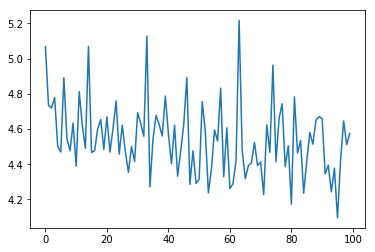

In [364]:
plt.plot(l)

In [116]:
#vocab_size = 100
#n_class=10

vocab_size = 200
n_class=20

d_model=32
enbedding_vector_size=32 #XXX
d_hidden=64

model = Memory(d_model=d_model, vocab_size=vocab_size, enbedding_vector_size=enbedding_vector_size, d_hidden=d_hidden ).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD( model.parameters(), lr=0.01 , momentum=0.9)

In [117]:
print(model)

Memory(
  (embedding): Embedding(200, 32)
  (encoder): EncoderRNN(
    (gru): GRU(32, 32, batch_first=True)
  )
  (ln): LayerNorm(torch.Size([32]), eps=1e-05, elementwise_affine=True)
  (decoder): FFN(
    (w1): Linear(in_features=64, out_features=64, bias=True)
    (w2): Linear(in_features=64, out_features=200, bias=True)
  )
)


In [121]:
optimizer = optim.SGD( model.parameters(), lr=0.001, momentum=0.9)

#data = Data(n_class=20, sequence_length=25, repeat_types=True, no_answer=True)
#test_iter = list(data.gen_iter(n_data=1000))

In [122]:
start = time()

data = Data(n_class=20, sequence_length=25, repeat_types=True, no_answer=True)
avg_loss = []
for i in range(5) :
    train_iter = list(data.gen_iter(n_data=10000, batch_size=16))
    l = train(model, optimizer, criterion, train_iter )
    m = np.mean(l)
    #print("mean iteration loss", m)
    avg_loss.append( m )
    print( test_accuracy(model, test_iter) )
    
end = time()
print (end-start)

0.705
0.703
0.715
0.712
0.728
278.53428864479065


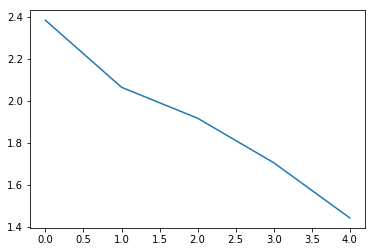

In [119]:
plt.plot(avg_loss)

In [102]:
d = Data(n_class=20, sequence_length=18, repeat_types=False, no_answer=True)
x,q,y = d.get_data()
#x,q,y = test_iter[57]
print (x,q,y)

tensor([[ 75, 158, 120,  65, 170,  21, 170, 110, 116, 108, 125, 186,  16, 190,
          73, 115,  93, 163, 110,  19,  71, 181,  11,  32, 107]],
       device='cuda:0') tensor([[12]], device='cuda:0') tensor([[125]], device='cuda:0')


In [103]:
s = model(x,q)
s = s.detach()
if y == s[0].topk(1)[1] :
    print("Correct")

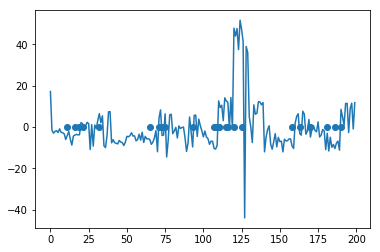

In [104]:
plt.plot(s[0].cpu().numpy())
plt.scatter(x.cpu().numpy(), np.zeros(x.shape[1]))

In [105]:
#print (x,q,y)
print(y,s[0].topk(1)[1])

tensor([[125]], device='cuda:0') tensor([124], device='cuda:0')


In [106]:
s[0].topk(10)

(tensor([51.6971, 47.8386, 47.6903, 47.2340, 44.0322, 41.2756, 38.9670, 37.4724,
         36.0653, 17.1677], device='cuda:0'),
 tensor([124, 120, 122, 125, 121, 126, 128, 123, 129,   0], device='cuda:0'))

In [1541]:
q = torch.tensor([7], dtype=torch.long)
y = torch.tensor([75], dtype=torch.long)

In [2105]:
d = Data(sequence_length=1000, repeat_types=True)
for c in range(1000) :
    x,q,y = d.get_data()
    s = model(x,q)
    s = s.detach()
    
    if y != s[0].topk(1)[1] :
        plt.plot(s[0].numpy())
        plt.scatter(x.numpy(), np.ones(x.shape[1]))
        print(c)
        break

In [2103]:
#print (x,q)
j = q.item()
print("ans ", [ i for i in x[0].numpy() if j*10 <= i <= j*10 +9 ] )
print("pred", s[0].topk(1)[1].item())
print(s[0].topk(10)[1])

tensor([[37, 88, 13, 98, 30, 96, 88, 79, 94, 91, 88, 31, 17, 66, 59, 84, 53, 98,
         58, 99, 70, 78, 69, 17, 59, 85, 71, 24, 44, 92, 71, 32, 88, 65, 98, 34,
         62, 48, 56, 74, 68, 35, 93, 23, 94, 65, 38, 37, 59, 45, 50, 31, 64, 80,
         68, 11, 94, 59, 25, 34, 62, 68, 20, 56, 69, 30, 81, 49, 85, 30, 97, 34,
         64, 22, 22, 36, 53, 66, 93, 36, 93, 23, 40, 37, 27, 96, 48, 50, 22, 40,
         57, 46, 35, 79, 19, 12, 93, 19, 17, 21]]) tensor([[2]])
ans  [24, 23, 25, 20, 22, 22, 23, 27, 22, 21]
pred 21
tensor([21, 24, 26, 23, 79, 46, 22, 27, 29, 50])


In [2083]:
s[0].topk(10)[1]

tensor([74, 78, 73, 68, 75, 76, 72, 71, 79, 70])

In [97]:
data = Data(n_class=20, sequence_length=25, repeat_types=True, no_answer=True)
test_iter = list(data.gen_iter(n_data=1000))
def test_accuracy(model, test_iter, debug_print=False) :
    count = 0
    n_data = 0
    for x,q,y in test_iter :
        x = x.to(device)
        q = q.to(device)
        y = y.to(device)
        
        s = model(x,q)
        s = s.detach()
        predicted = s[0].topk(1)[1].item()
        if predicted == y.item() :
            count += 1
        else :
            if debug_print :
                print(x,q,y,predicted)
        n_data += 1.0
    return count/n_data

In [98]:
test_accuracy(model, test_iter, debug_print=False)

0.296

In [1973]:
l = []
for i in range(8,100) :
    data = Data(sequence_length=i, repeat_types=True)
    test_iter = list(data.gen_iter(n_data=100))
    accuracy = test_accuracy(model, test_iter, debug_print=False)
    l.append( accuracy )
    #print(i, accuracy )

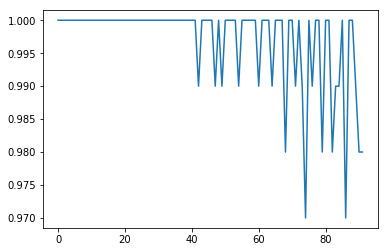

In [1974]:
plt.plot(l)

In [1028]:
model.parameters()

<generator object Module.parameters at 0x7faaf4df7570>

In [70]:
print(model)

Memory(
  (embedding): Embedding(100, 32)
  (encoder): EncoderRNN(
    (gru): GRU(32, 32, batch_first=True)
  )
  (ln): LayerNorm(torch.Size([32]), eps=1e-05, elementwise_affine=True)
  (decoder): FFN(
    (w1): Linear(in_features=64, out_features=32, bias=True)
    (w2): Linear(in_features=32, out_features=100, bias=True)
  )
)


In [72]:
w = model.embedding.weight.data.clone().cpu().numpy()

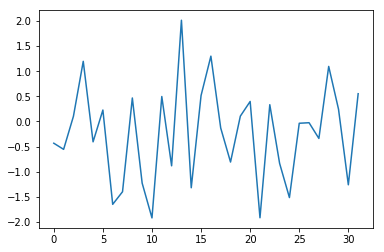

In [73]:
plt.plot(w[:][76])

In [74]:
index = 77
s = [ (np.dot(w[index,:], w[i,:])/(np.linalg.norm(w[index,:])*np.linalg.norm(w[i,:])), i) for i in range(100) ]

In [75]:
sorted(s)

[(-0.3581399, 0),
 (-0.32853588, 84),
 (-0.30906513, 38),
 (-0.29597405, 96),
 (-0.25231612, 86),
 (-0.2329015, 51),
 (-0.22420971, 41),
 (-0.20024563, 68),
 (-0.19629252, 55),
 (-0.19485566, 87),
 (-0.19214684, 31),
 (-0.18592827, 53),
 (-0.17766318, 65),
 (-0.1768761, 6),
 (-0.16880122, 33),
 (-0.15842922, 26),
 (-0.15078445, 85),
 (-0.1505511, 90),
 (-0.14515159, 67),
 (-0.14367667, 91),
 (-0.13799709, 83),
 (-0.13623235, 46),
 (-0.12101032, 66),
 (-0.11695313, 99),
 (-0.111498535, 45),
 (-0.11090777, 22),
 (-0.105421074, 44),
 (-0.103289075, 80),
 (-0.09672253, 20),
 (-0.09506165, 32),
 (-0.09431063, 89),
 (-0.086406365, 54),
 (-0.08446691, 13),
 (-0.08236803, 61),
 (-0.08052423, 48),
 (-0.07953244, 62),
 (-0.075221255, 56),
 (-0.07397235, 97),
 (-0.07328975, 69),
 (-0.06910045, 30),
 (-0.0690379, 52),
 (-0.067000955, 88),
 (-0.06671691, 64),
 (-0.06180029, 58),
 (-0.060441725, 21),
 (-0.06026764, 23),
 (-0.058737315, 98),
 (-0.035661604, 15),
 (-0.035210438, 24),
 (-0.03132054, 59

In [77]:
q.shape

torch.Size([1, 1])

In [78]:
a

tensor([[68]], device='cuda:0')